In [ ]:
#prepare dataset

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load feature engineered dataset
fraud_df = pd.read_csv("fraud_features.csv")

# Define X and y
X = fraud_df.drop(columns=['Class'])
y = fraud_df['Class']

# Train-test split (stratify to preserve fraud ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
#Summary:

#Start with Logistic Regression baseline.

#Improve with XGBoost / LightGBM (use scale_pos_weight).

#Explore anomaly detection models.

#Scale with Spark MLlib.

#Explain results with SHAP.

In [6]:
#Baseline — Logistic Regression

#Use class_weight='balanced' to handle imbalance.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

lr = LogisticRegression(class_weight='balanced', max_iter=4000, random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.92      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962

ROC-AUC: 0.9734250463691385


C:\Users\shiks\Documents\fraud-loans-project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 6000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=6000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
#Tree-based models

In [ ]:
#xgboost

In [10]:
import xgboost as xgb

scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

xgb_clf = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)
xgb_clf.fit(X_train, y_train)

print("XGBoost ROC-AUC:", roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1]))


C:\Users\shiks\Documents\fraud-loans-project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:32:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost ROC-AUC: 0.976582687802189


In [12]:
#lightGBM

In [15]:
import lightgbm as lgb

scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

lgb_clf = lgb.LGBMClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
lgb_clf.fit(X_train, y_train)

print("LightGBM ROC-AUC:", roc_auc_score(y_test, lgb_clf.predict_proba(X_test)[:,1]))


[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339
LightGBM ROC-AUC: 0.9315718743181008


In [16]:
#Anomaly Detection

In [17]:
#Isolation Forest

In [18]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.01, random_state=42)
y_pred_iso = iso.fit_predict(X_test)

# Convert: -1 = anomaly (fraud), 1 = normal
y_pred_iso = [1 if val==-1 else 0 for val in y_pred_iso]
print(classification_report(y_test, y_pred_iso))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.10      0.60      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.80      0.59     56962
weighted avg       1.00      0.99      0.99     56962



In [19]:
#Autoencoders (Tensorflow/Keras)

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

input_dim = X_train.shape[1]
encoding_dim = 14  # compressed size

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="sigmoid")(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.fit(X_train, X_train, epochs=10, batch_size=64, shuffle=True, validation_split=0.2)

# Reconstruction error
recon = autoencoder.predict(X_test)
mse = ((X_test - recon)**2).mean(axis=1)


Epoch 1/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 312468128.0000 - val_loss: 313767744.0000
Epoch 2/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 312467584.0000 - val_loss: 313767744.0000
Epoch 3/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 312468096.0000 - val_loss: 313767744.0000
Epoch 4/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 312467840.0000 - val_loss: 313767744.0000
Epoch 5/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 312467584.0000 - val_loss: 313767744.0000
Epoch 6/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 312467840.0000 - val_loss: 313767744.0000
Epoch 7/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 312467968.0000 - val_loss: 313767744.0000
Epoch 8/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 312467744.0000 - val_loss: 313767744.0000
Epoch 9/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 312467872.0000 - val_loss: 313767744.0000
Epoch 10/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3

In [24]:
#making a threshold
#The Autoencoder learns to reconstruct “normal” transactions well, but struggles with fraudulent ones.
#So we compute the Reconstruction Error (MSE) and set a threshold:

#If error ≤ threshold → Normal (0)

#If error > threshold → Fraud (1)

In [30]:
#Use a quantile (e.g., 95th percentile of errors from training set)
#Autoencoders works best while normalized.
import numpy as np
# Reconstruction error on train set (assuming "mostly normal")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train autoencoder on scaled data
autoencoder.fit(X_train_scaled, X_train_scaled, 
                epochs=10, batch_size=64, shuffle=True, validation_split=0.2)

# Reconstruction error (scaled)
recon_train = autoencoder.predict(X_train_scaled)
mse_train = np.mean(np.power(X_train_scaled - recon_train, 2), axis=1)

threshold = np.percentile(mse_train, 95)
print("Threshold:", threshold)



Epoch 1/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.8042 - val_loss: 0.7495
Epoch 2/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7607 - val_loss: 0.7327
Epoch 3/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.7492 - val_loss: 0.7249
Epoch 4/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7432 - val_loss: 0.7206
Epoch 5/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.7391 - val_loss: 0.7166
Epoch 6/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.7358 - val_loss: 0.7143
Epoch 7/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.7337 - val_loss: 0.7126
Epoch 8/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7320 - val_loss: 0.7110
Epoch 9/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7306 - val_loss: 0.7098
Epoch 10/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.7298 - val_loss: 0.7091
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Threshold: 1.343883599533771


In [31]:
recon_test = autoencoder.predict(X_test_scaled)
mse_test = np.mean(np.power(X_test_scaled - recon_test, 2), axis=1)

y_pred = (mse_test > threshold).astype(int)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [32]:
#Use ROC curve to find best cutoff

fpr, tpr, thresholds = roc_curve(y_test, mse_test)
optimal_idx = np.argmax(tpr - fpr)
threshold = thresholds[optimal_idx]
print("Optimal threshold:", threshold)

Optimal threshold: 1.5576717343188275


In [33]:
#Classify fraud vs non-fraud

y_pred = (mse > threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[    1 56863]
 [    0    98]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     56864
           1       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.50      0.50      0.00     56962
weighted avg       1.00      0.00      0.00     56962



In [37]:
#Spark MLlib (big data pipeline)
#in this case the dataset is not very large, but spark MLlib helps in scalability

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("FraudDetection").getOrCreate()

# Load as Spark DataFrame
fraud_spark = spark.read.csv("fraud_features.csv", header=True, inferSchema=True)

# Features + label
assembler = VectorAssembler(
    inputCols=[col for col in fraud_spark.columns if col != "Class"],
    outputCol="features"
)
fraud_spark = assembler.transform(fraud_spark)

(train, test) = fraud_spark.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestClassifier(labelCol="Class", featuresCol="features")
model = rf.fit(train)
predictions = model.transform(test)
predictions.select("prediction","probability","Class").show(20)


+----------+--------------------+-----+
|prediction|         probability|Class|
+----------+--------------------+-----+
|       0.0|[0.99971065899915...|    0|
|       0.0|[0.99974127164043...|    0|
|       0.0|[0.99967207536784...|    0|
|       0.0|[0.99974127164043...|    0|
|       0.0|[0.99974127164043...|    0|
|       0.0|[0.99974127164043...|    0|
|       0.0|[0.99974127164043...|    0|
|       0.0|[0.99974127164043...|    0|
|       0.0|[0.99974127164043...|    0|
|       0.0|[0.99974127164043...|    0|
|       0.0|[0.99974127164043...|    0|
|       0.0|[0.99974127164043...|    0|
|       0.0|[0.99974127164043...|    0|
|       0.0|[0.99974127164043...|    0|
|       0.0|[0.99895359909469...|    0|
|       0.0|[0.99974127164043...|    0|
|       0.0|[0.99974127164043...|    0|
|       0.0|[0.99974127164043...|    0|
|       0.0|[0.99975889556008...|    0|
|       0.0|[0.99952707930782...|    0|
+----------+--------------------+-----+
only showing top 20 rows



C:\Users\shiks\Documents\fraud-loans-project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


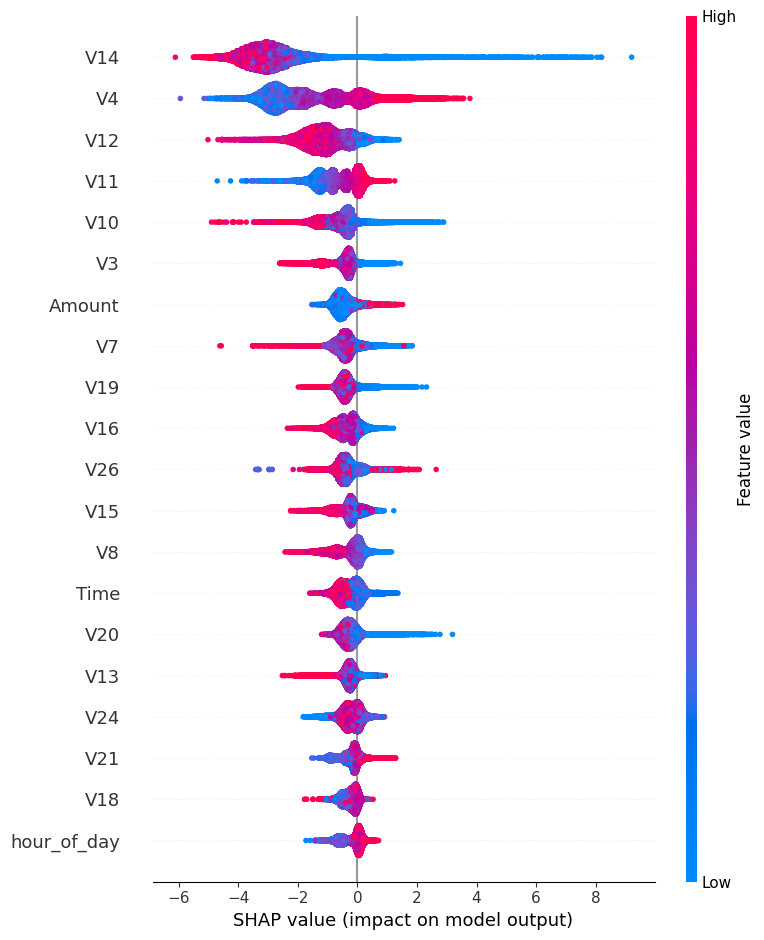

In [38]:
#interpretability

import shap

explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


#### Key Takeaways from Modeling

1. Fraud detection is an imbalanced problem → normal accuracy is useless, use Precision-Recall AUC, F1, and confusion matrix.

2. Logistic Regression = good baseline, interpretable.

3. XGBoost/LightGBM = strong supervised models for fraud.

4. Autoencoder = strong anomaly detection, but needs scaling + careful thresholding.

5. Spark MLlib = scalable version of same models, fits into a big-data pipeline.

6. SHAP = provides feature importance & interpretability.

In [39]:
# fraud evaluation

Fraud is rare → Accuracy is useless. We need:

1. Precision → % of predicted frauds that are truly fraud.
2. Recall → % of actual frauds we caught.
3. F1-score → balance of precision & recall.
4. PR AUC (Precision-Recall AUC) → better summary metric for imbalanced problems.

In [40]:
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, confusion_matrix, roc_auc_score

# Model probabilities
y_scores = xgb_clf.predict_proba(X_test)[:,1]

# Confusion Matrix + Report
y_pred = (y_scores > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ROC-AUC
print("ROC-AUC:", roc_auc_score(y_test, y_scores))

# PR-AUC
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)
print("PR-AUC:", pr_auc)


[[56853    11]
 [   17    81]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.976582687802189
PR-AUC: 0.8728531052783094


In [41]:
#Time-based Split

In [43]:
# Example: train = first 80%, test = last 20%
cutoff = int(len(fraud_df) * 0.7)
train = fraud_df.iloc[:cutoff]
test  = fraud_df.iloc[cutoff:]


In [45]:
#Cross-Validation Strategy
#fraud- time dependent

In [47]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = LogisticRegression(class_weight='balanced', max_iter=2000)
scores = cross_val_score(model, X, y, cv=skf, scoring='average_precision')  # PR-AUC
print("Mean PR-AUC:", scores.mean())


C:\Users\shiks\Documents\fraud-loans-project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\shiks\Documents\fraud-loans-project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-lear

KeyboardInterrupt: 